# Notebook description

This notebook is for developing the quadratic integrate-and-fire (QIF) neuron.

# The QIF dynamics

The QIF neuron dynamics follows

\begin{equation*}
 \tau \dot{x} = -x + \frac{x^2}{2} + u
\end{equation*}

where $x$ is the state of the neuron, $\tau$ is the membrane time constant, and $u$ is the neuron input. The firing rate is given by

\begin{equation*}
f = \frac{1}{t_{ref}+t_{spk}}
\end{equation*}

where $t_{ref}$ is the refractory period and $t_{spk}$ is the interval from the end of the refractory period to when the neuron spikes. A neuron is considered to have spiked when its state reaches $\infty$. The cool thing about the QIF neuron is that it can reach $\infty$ in finite time given the appropriate initial condition or input. To find the inter-spike interval, we integrate from the end of the refractory period to the spike time. Assuming the refractory period ended at $t=0$,

\begin{align*}
\tau \frac{dx}{dt} &= -x + \frac{x^2}{2} + u \\
dt &= \frac{\tau}{-x + \frac{x^2}{2} + u}dx \\
\int_0^{t_{spk}}dt &= \int_0^\infty\frac{\tau}{-x + \frac{x^2}{2} + u}dx \\
t_{spk} &= \frac{\tau  \left(\pi + 2 \cot ^{-1}\left(\sqrt{2u-1}\right)\right)}{\sqrt{2u-1}} 
    & \mathrm{for}\;u\ge0.5 \\
\end{align*}

In fact, it is possible to solve the QIF neuron dynamics analytically. The actual solution to the QIF neuron is given by [???]

This solution shows that the QIF neuron actually resets to $-\infty$ and begins integrating again

Unfortunately in software, we can't integrate to $\infty$. Instead we set a threshold $x_t$ at which point the neuron is declared to have spiked, and when a neuron reaches threshold, we reset the neuron to $0$. In this way, the software QIF neuron spikes just like the LIF neuron. This conscession changes the spike rate of the neuron

\begin{align*}
t_{spk} &= \int_0^{x_t}\frac{\tau}{-x + \frac{x^2}{2} + u}dx \\
 &= \frac{2\tau\left(\cot^{-1}\left(\frac{\sqrt{2u-1}}{x_t-1}\right)+
    \cot^{-1}\left(\sqrt{2u-1}\right)\right)}
     {\sqrt{2u-1}}
     & \mathrm{for}\;u\ge0.5 \\
\end{align*}

# Setup

In [1]:
%matplotlib inline
import numpy as np
from numpy.random import lognormal
import matplotlib.pyplot as plt

import nengo
from nengo.builder import Builder
from nengo.builder.signal import Signal
from nengo.builder.neurons import SimNeurons
from nengo.params import NumberParam
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Uniform

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
class QIFRate(nengo.neurons.NeuronType):  # Neuron types must subclass `nengo.Neurons`
    """A rate-based quadratic integrate-and-fire neuron model"""   
    tau_rc = NumberParam(low=0, low_open=True)
    tau_ref = NumberParam(low=0)
    probeable = ['rates']
    threshold = 10.0  # spike threshold

    def __init__(self, tau_rc=.01, tau_ref=.002, gb_tol=1e-6):
        self.tau_rc = tau_rc
        self.tau_ref = tau_ref
        self.gb_tol=gb_tol  # tolerance in gain_bias binary search

    def gain_bias(self, max_rates, intercepts):
        """Compute the alpha and bias needed to satisfy max_rates, intercepts
        
        Returns gain (alpha) and offset (J_bias) values of neurons.
        
        Parameters
        ----------
        max_rates : array of floats
            Maximum firing rates of neurons
        intercepts : array of floats
            x-intercepts of neurons
        """
        inv_tau_ref = 1./self.tau_ref if self.tau_ref > 0. else np.inf
        if (max_rates > inv_tau_ref).any():
            raise ValueError(
                "Max rates must be below the inverse refractory period (%0.3f)"
                % (inv_tau_ref))
        
        tspk_min = 1./max_rates - self.tau_ref
        
        J0 = np.zeros_like(tspk_min) + 0.5
        J1 = J0.copy()
        tspk = np.zeros_like(tspk_min) + np.inf
        J_max = np.zeros_like(tspk_min)
        
        # First binary search to find the correct range of J_max
        idx = np.ones(tspk_min.shape, dtype=bool)
        while idx.any():
            J0[idx] = J1[idx]
            J1[idx] *= 2
            tspk[idx] = self._tspk(J1[idx])
            idx[tspk < tspk_min] = False
        
        # Second binary search to find J_max
        idx[:] = True
        while idx.any():
            J_max[idx] = 0.5*(J0[idx]+J1[idx])
            tspk[idx] = self._tspk(J_max[idx])
            
            idx[np.abs(tspk - tspk_min) < self.gb_tol] = False
            high_idx = np.logical_and(idx, tspk < tspk_min)
            low_idx = np.logical_and(idx, tspk > tspk_min)
            
            J1[high_idx] = J_max[high_idx]
            J0[low_idx] = J_max[low_idx]

        # compute gain and bias from J_max and intercepts
        gain = (0.5 - J_max) / (intercepts - 1.)
        bias = 0.5 - gain*intercepts
        return gain, bias

    def _tspk(self, J):
        xt = self.threshold
        tspk = (2*self.tau_rc * 
            (np.arctan((xt-1)/np.sqrt(2*J-1))+np.arctan(1./np.sqrt(2*J-1)))/
            np.sqrt(2*J-1))
        return tspk
    
    def step_math(self, dt, J, output):
        idx = J > .5
        output[idx] = (self.tau_ref + self._tspk(J[idx]))**-1
        output[~idx] = 0.

    def rates(self, x, gain, bias):
        J = gain * x + bias
        out = np.zeros_like(J)
        QIFRate.step_math(self, dt=1, J=J, output=out)
        return out

# Register the QIFRate model with Nengo
@Builder.register(QIFRate)
def build_qifrate(model ,qifrate, neurons):
    model.add_op(SimNeurons(
        neurons=qifrate,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out']))

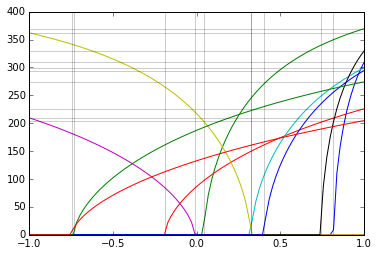

In [3]:
# check that gain_bias produces the correct tuning curves
net = nengo.Network()
with net:
    ens = nengo.Ensemble(10, 1, neuron_type=QIFRate())
sim = nengo.Simulator(net)
x = np.linspace(-1, 1, 100).reshape((-1,1))
eval_points, activities = tuning_curves(ens, sim, x)
plt.plot(eval_points, activities);
for max_rate in sim.data[ens].max_rates:
    plt.axhline(max_rate, color='k', alpha=.2)
for intercept in sim.data[ens].intercepts*sim.data[ens].encoders.reshape(-1):
    plt.axvline(intercept, color='k', alpha=.2)

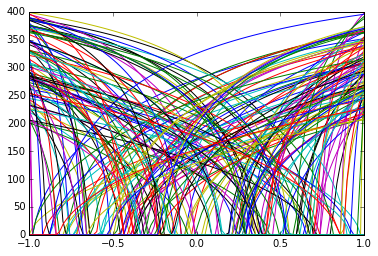

In [4]:
# check that gain_bias produces the correct tuning curves
net = nengo.Network()
with net:
    ens = nengo.Ensemble(200, 1, neuron_type=QIFRate())
sim = nengo.Simulator(net)
x = np.linspace(-1, 1, 100).reshape((-1,1))
eval_points, activities = tuning_curves(ens, sim, x)
plt.plot(eval_points, activities);

In [5]:
class QIF(QIFRate):
    """A spiking quadratic leaky-integrate-and-fire neuron model"""
    probeable = ['spikes', 'voltage', 'refractory_time']
    def _vdot(self, J, voltage):
        dvdt = (-voltage + voltage**2/2 + J) / self.tau_rc
        return dvdt

    def rates(self, x, gain, bias):
        return QIFRate.rates(self, x, gain, bias)
        
    def step_math(self, dt, J, spiked, voltage, refractory_time):        
        # Use Heun's method
        vv = voltage
        dvdt = self._vdot(J, vv)
        v = vv + dt*dvdt
        dvdt2 = self._vdot(J, v)
        dvdt_avg = (dvdt+dvdt2)/2.
        dv = dt*dvdt_avg

        # Use the Runge-Kutta method
#         k1 = self._vdot(J, voltage)
#         k2 = self._vdot(J, voltage + dt/2*k1)
#         k3 = self._vdot(J, voltage + dt/2*k2)
#         k4 = self._vdot(J, voltage + dt*k3)
#         dv = dt/6.*(k1 + 2*k2 + 2*k3 + k4)
        
        voltage += dv
        
        # update refractory period assuming no spikes for now
        refractory_time -= dt
        
        # set voltages of neurons still in their refractory period to 0
        # and reduce voltage of neurons partway out of their ref. period
        voltage *= (1 - refractory_time / dt).clip(0, 1)
        
        # determine which neurons spike 
        spiked[:] = np.where(voltage > QIFRate.threshold, 1.0/dt, 0.0)

        # linearly approximate the time since neuron crossed spike threshold
        overshoot = (voltage[spiked > 0] - QIFRate.threshold) / dv[spiked > 0]
        spiketime = dt * (1 - overshoot)
        
        # set spiking neurons' voltages to zero, and ref. time to tau_ref
        voltage[spiked > 0] = 0.
        refractory_time[spiked > 0] = self.tau_ref + spiketime
        

# Register the QIF_heun model with Nengo
# You should not have to modify this
@Builder.register(QIF)
def build_qif(model, qif, neurons):
    model.sig[neurons]['voltage'] = Signal(
        np.zeros(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['refractory_time'] = Signal(
        np.zeros(neurons.size_in), name="%s.refractory_time" % neurons)
    model.add_op(SimNeurons(
        neurons=qif,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
                model.sig[neurons]['refractory_time']]))

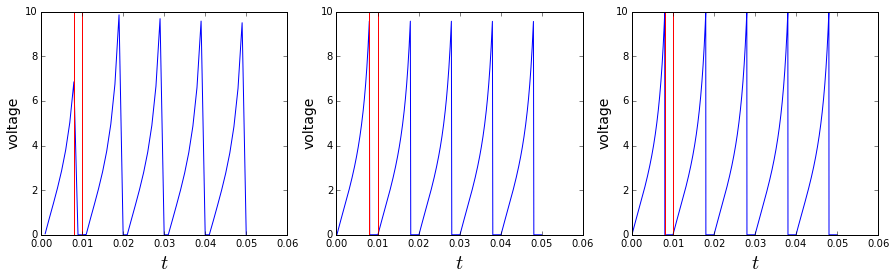

In [6]:
## voltage plot
dts = [.001, .0001, .00001]
max_rate = 100.
tau_ref = .002
tspk = 1./max_rate - tau_ref
T = 5./max_rate
net = nengo.Network()
with net:
    stim = nengo.Node(1.)
    ens = nengo.Ensemble(1, 1, neuron_type=QIF(tau_ref=tau_ref),
                         encoders=np.ones((1, 1)),
                         max_rates=np.array([max_rate]),
                         intercepts=np.array([0.]))
    nengo.Connection(stim, ens, synapse=0)
    probe_v = nengo.Probe(ens.neurons, 'voltage')
fig, axs = plt.subplots(ncols=3, figsize=(15,4), sharex=True)
for idx, dt in enumerate(dts):
    sim = nengo.Simulator(net, dt=dt)
    sim.run(T, progress_bar=False)
    t = sim.trange()
    axs[idx].plot(sim.trange(), sim.data[probe_v])
    axs[idx].set_ylabel('voltage', fontsize=14)
    axs[idx].set_xlabel(r'$t$', fontsize=20)
    axs[idx].axvline(tspk, color='r')
    axs[idx].axvline(1./max_rate, color='r')

In [7]:
def check_tuning_curve_accuracy(neuron_type):
    """Takes in a neuron model (e.g. QIF) and checks the accuracy"""
    N = 5
    k = 30
    xs = np.linspace(-1., 1., k)
    T = 1.
    dt = .0001

    net = nengo.Network()
    with net:
        stim = nengo.Node(0.)
        ens = nengo.Ensemble(N, 1, encoders=np.ones((N,1)),
                             neuron_type=neuron_type)
        nengo.Connection(stim, ens, synapse=0.)
        probe_s = nengo.Probe(ens.neurons, 'spikes')
        probe_v = nengo.Probe(ens.neurons, 'voltage')
    sim = nengo.Simulator(net)
    gain = sim.data[ens].gain
    bias = sim.data[ens].bias
    ens.gain = gain
    ens.bias = bias
        
    a_hat = np.zeros((k, N))
    for x_idx, x in enumerate(xs):
        stim.output = x
        sim = nengo.Simulator(net, dt=dt)
        sim.run(T, progress_bar=False)
        t = sim.trange()
        spike_dat = sim.data[probe_s]
        for n in xrange(N):
            spike_times = t[np.nonzero(spike_dat[:, n])[0]]
            if len(spike_times) == 0:
                a_hat[x_idx, n] = 0
            elif len(spike_times) == 1:
                a_hat[x_idx, n] = 1./T
            else:
                isi = np.diff(spike_times)
                a_hat[x_idx, n] = 1./np.mean(isi)

    sim = nengo.Simulator(net)
    _, a = tuning_curves(ens, sim, inputs=xs.reshape((-1,1)))

    a_error = a - a_hat

    fig, axs = plt.subplots(ncols=2, figsize=(15,5))
    for n in xrange(N):
        l = axs[0].plot(xs, a[:, n])[0]
        axs[0].plot(xs, a_hat[:, n], 'o'+l.get_color(), ms=6)
        axs[0].set_xlabel(r'$x$', fontsize=20)
        axs[0].set_ylabel(r'$a,\ \hat{a}$', fontsize=20)
        axs[1].plot(xs, a_error[:, n], l.get_color())
        axs[1].set_xlabel(r'$x$', fontsize=20)
        axs[1].set_ylabel(r'$a-\hat{a}$', fontsize=20);

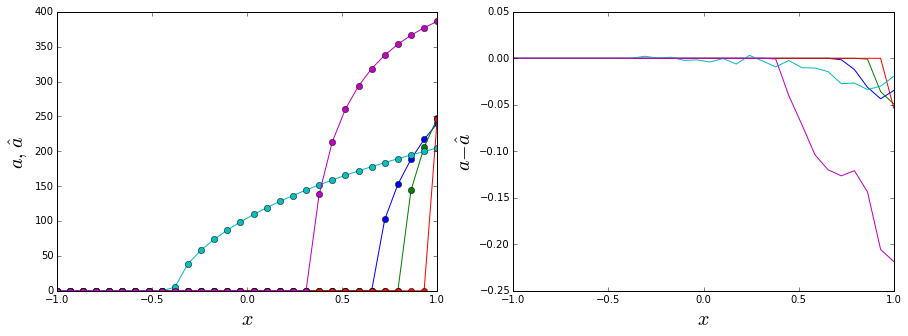

In [8]:
check_tuning_curve_accuracy(QIF())